# Importing the necessary libraries

In [132]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, make_scorer
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, log_loss
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import class_weight
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation, Concatenate, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Loading the Dataset (COVID_numerics)

In [133]:
data = pd.read_csv('COVID_numerics.csv')

print(data.head())

# Dataset dimensions
print(f"\nLines: {data.shape[0]}, Columns: {data.shape[1]}")

   GENDER   AGE  MARITAL STATUS  VACINATION  RESPIRATION CLASS  HEAR RATE  \
0     0.0  71.0             1.0         1.0                1.0  83.456271   
1     0.0  82.0             1.0         0.0                3.0  79.449753   
2     1.0  65.0             0.0         0.0                3.0  85.470779   
3     1.0  64.0             0.0         0.0                1.0  51.561135   
4     0.0  85.0             1.0         0.0                2.0  89.008377   

   SYSTOLIC BLOOD PRESSURE  TEMPERATURE  TARGET  Unnamed: 9  
0                135.09198    37.503016     0.0         NaN  
1                132.81408    36.832310     1.0         NaN  
2                137.33184    37.580005     1.0         NaN  
3                149.29652    36.959370     0.0         NaN  
4                121.42689    37.744883     1.0         NaN  

Lines: 600, Columns: 10


# Data Visualization (COVID_numerics)

In [134]:
print(data.describe())

# missing values
print(data.isnull().sum())

           GENDER         AGE  MARITAL STATUS  VACINATION  RESPIRATION CLASS  \
count  600.000000  600.000000      600.000000  600.000000         600.000000   
mean     0.525000   64.678333        0.510000    0.490000           1.496667   
std      0.499791   12.184511        0.500317    0.500317           1.123429   
min      0.000000   26.000000        0.000000    0.000000           0.000000   
25%      0.000000   56.000000        0.000000    0.000000           0.000000   
50%      1.000000   64.500000        1.000000    0.000000           1.000000   
75%      1.000000   72.000000        1.000000    1.000000           3.000000   
max      1.000000  107.000000        1.000000    1.000000           3.000000   

        HEAR RATE  SYSTOLIC BLOOD PRESSURE  TEMPERATURE      TARGET  \
count  600.000000               600.000000   600.000000  600.000000   
mean    67.803942               140.790133    37.475342    0.321667   
std     24.116513                14.504561     0.847720    0.46750

Class Distribution in COVID_numerics.csv:
TARGET
0.0    407
1.0    193
Name: count, dtype: int64


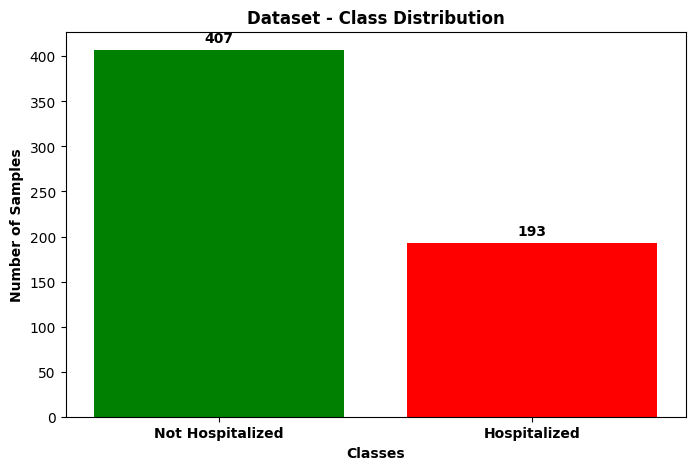

In [135]:
# Count the classes in the TARGET variable
class_counts = data['TARGET'].value_counts()
print("Class Distribution in COVID_numerics.csv:")
print(class_counts)

# Plot the distribution with labels and legend
plt.figure(figsize=(8, 5))
bars = plt.bar(class_counts.index, class_counts.values, color=['green', 'red'])

# Add values above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add title, labels, and explanatory legends
plt.title("Dataset - Class Distribution", fontweight='bold')
plt.xlabel("Classes", fontweight='bold')
plt.ylabel("Number of Samples", fontweight='bold')
plt.xticks([0, 1], ["Not Hospitalized", "Hospitalized"], fontweight='bold')

# Show the plot
plt.show()

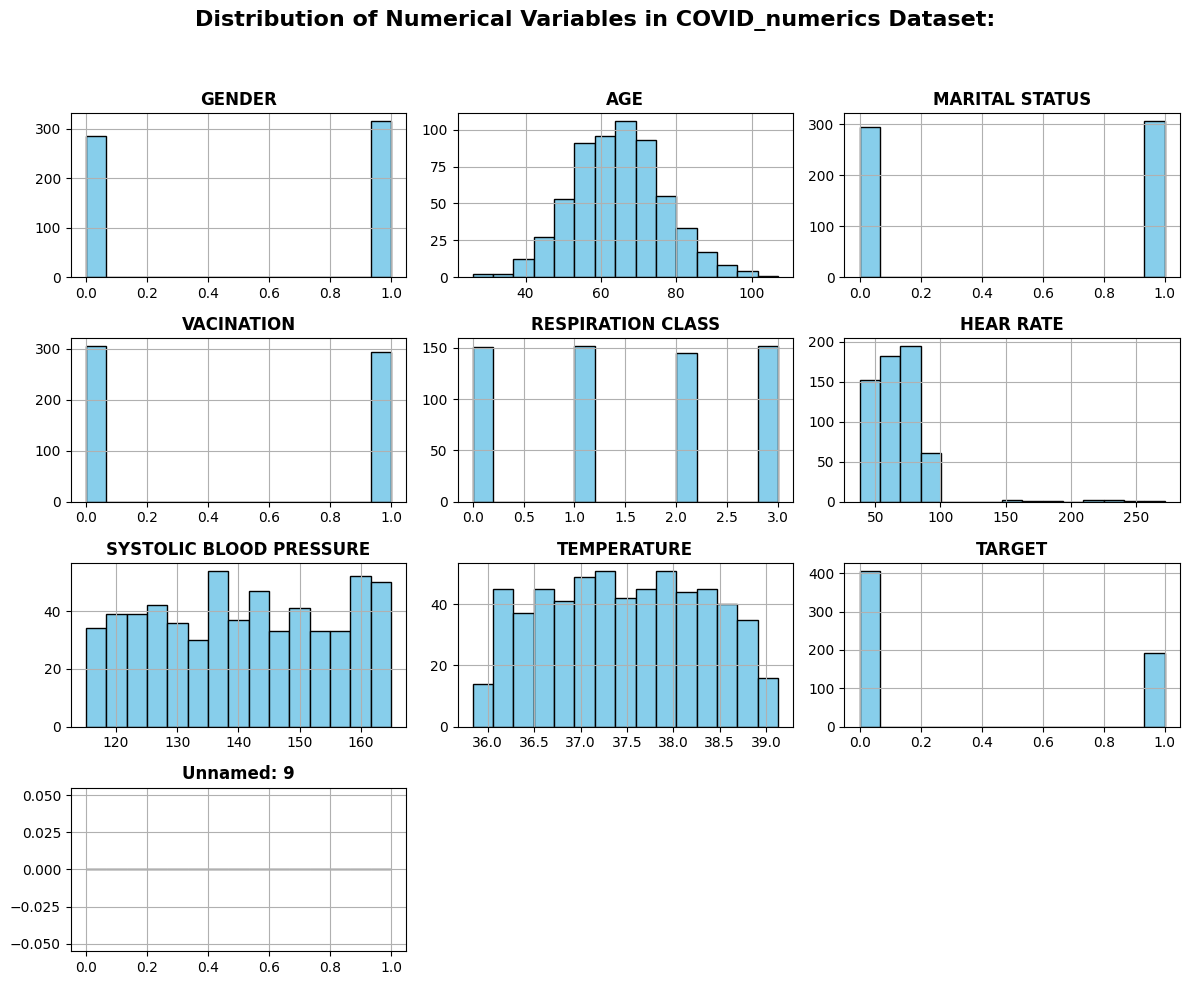

In [136]:
# Histogram for numerical variables
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Plot histograms
data[numerical_columns].hist(figsize=(12, 10), bins=15, color='skyblue', edgecolor='black')

plt.suptitle("Distribution of Numerical Variables in COVID_numerics Dataset:", fontsize=16, fontweight='bold')

for ax in plt.gcf().axes: 
    ax.set_title(ax.get_title(), fontsize=12, fontweight='bold')  
    ax.set_xlabel(ax.get_xlabel(), fontsize=10, fontweight='bold') 
    ax.set_ylabel(ax.get_ylabel(), fontsize=10, fontweight='bold') 

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Loading the Dataset (COVID_IMG)

In [137]:
covid_img = pd.read_csv("COVID_IMG.csv", header=None)

# Dataset dimensions
print("Dataset dimensions:", covid_img.shape)

print(covid_img.head())

# Number of columns
num_columns = covid_img.shape[1]
print(f"Number of columns: {num_columns}")

Dataset dimensions: (600, 441)
   0    1    2    3    4    5    6    7    8    9    ...  431  432  433  434  \
0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  1.0  1.0  1.0   
1  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  1.0   
2  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  1.0  1.0  0.0   
4  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0   

   435  436  437  438  439  440  
0  1.0  0.0  0.0  0.0  0.0  0.0  
1  1.0  1.0  0.0  1.0  0.0  0.0  
2  0.0  1.0  1.0  1.0  1.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  1.0  0.0  0.0  0.0  

[5 rows x 441 columns]
Number of columns: 441


# Data Visualization (COVID_IMG)

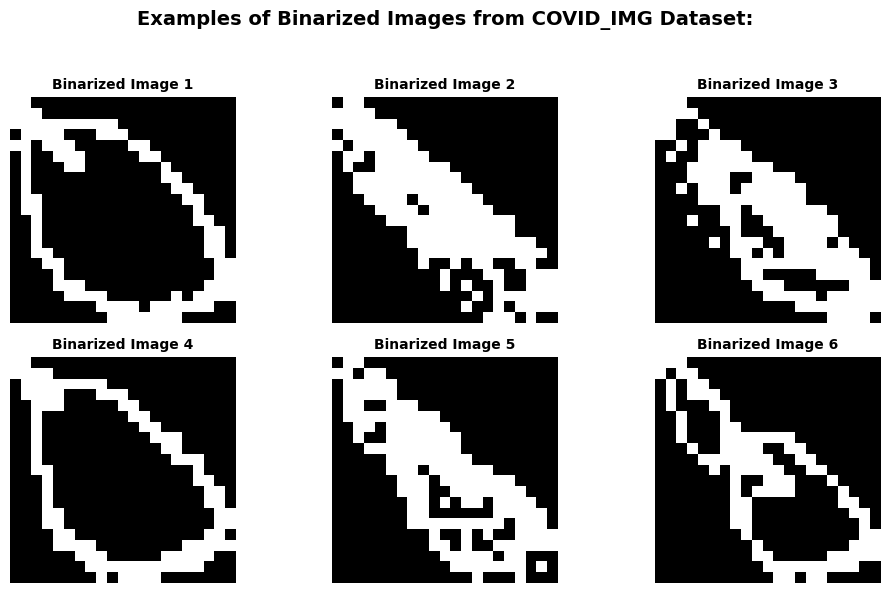

In [138]:
# visualization for binarized images
img_data = covid_img.values.reshape(-1, 21, 21, 1)
img_data_bin = (img_data > 0.5).astype(int)

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img_data_bin[i].squeeze(), cmap='gray')
    plt.title(f"Binarized Image {i+1}", fontsize=10, fontweight='bold')
    plt.axis('off')

plt.suptitle("Examples of Binarized Images from COVID_IMG Dataset:", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Full Dataset Visualization

## Not Hospitalized Pacient

Patient 1 - Numeric Data:
GENDER                       0.000000
AGE                         71.000000
MARITAL STATUS               1.000000
VACINATION                   1.000000
RESPIRATION CLASS            1.000000
HEAR RATE                   83.456271
SYSTOLIC BLOOD PRESSURE    135.091980
TEMPERATURE                 37.503016
TARGET                       0.000000
Unnamed: 9                        NaN
Name: 0, dtype: float64
Patient 1 - Image Data:


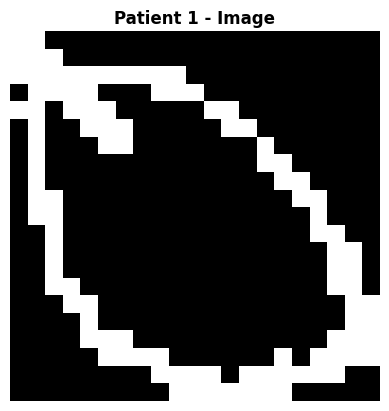

In [139]:
print(f"Patient {1} - Numeric Data:")
print(data.iloc[0])
print(f"Patient {1} - Image Data:")
plt.imshow(covid_img.iloc[0].values.reshape(21, 21), cmap='gray')
plt.title(f"Patient {1} - Image", fontweight='bold')
plt.axis('off')
plt.show()

## Hospitalized Pacient

Patient 2 - Numeric Data:
GENDER                       0.000000
AGE                         82.000000
MARITAL STATUS               1.000000
VACINATION                   0.000000
RESPIRATION CLASS            3.000000
HEAR RATE                   79.449753
SYSTOLIC BLOOD PRESSURE    132.814080
TEMPERATURE                 36.832310
TARGET                       1.000000
Unnamed: 9                        NaN
Name: 1, dtype: float64
Patient 2 - Image Data:


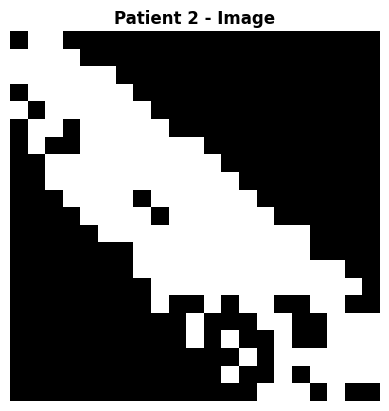

In [140]:
print(f"Patient {2} - Numeric Data:")
print(data.iloc[1]) 
print(f"Patient {2} - Image Data:")
plt.imshow(covid_img.iloc[1].values.reshape(21, 21), cmap='gray')
plt.title(f"Patient {2} - Image", fontweight='bold')
plt.axis('off')
plt.show()

# Data Preprocessing (COVID_numerics and COVID_IMG)

In [141]:
# Remove the column "Unnamed: 9"
data = data.drop(columns=['Unnamed: 9'])

# Separate Features and Target
X_num = data.drop(columns=['TARGET'])
y = data['TARGET']

# Normalize Image Data (Pixel values scaled to [0, 1])
X_img_normalized = img_data_bin / 255.0

# Flatten Images (for later processing on SMOTE)
X_flat = X_img_normalized.reshape(X_img_normalized.shape[0], -1)

# Concatenate Flattened Images and Tabular Data
X_combined = np.hstack([X_flat, X_num.values])

# Split into Training, Validation, and Test Sets (60/20/20) BEFORE applying SMOTE
X_train_combined, X_temp_combined, y_train, y_temp = train_test_split(
    X_combined, y, test_size=0.4, stratify=y, random_state=42
)
X_val_combined, X_test_combined, y_val, y_test = train_test_split(
    X_temp_combined, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Apply SMOTE ONLY to the Training Set
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_combined_res, y_train_res = smote.fit_resample(X_train_combined, y_train)

# Normalize Tabular Data AFTER SMOTE
scaler = StandardScaler()
X_train_combined_res[:, X_flat.shape[1]:] = scaler.fit_transform(X_train_combined_res[:, X_flat.shape[1]:])
X_val_combined[:, X_flat.shape[1]:] = scaler.transform(X_val_combined[:, X_flat.shape[1]:])
X_test_combined[:, X_flat.shape[1]:] = scaler.transform(X_test_combined[:, X_flat.shape[1]:])

# Print Class Distributions
print("Training distribution (after SMOTE):", dict(zip(*np.unique(y_train_res, return_counts=True))))
print("Validation distribution:", dict(zip(*np.unique(y_val, return_counts=True))))
print("Test distribution:", dict(zip(*np.unique(y_test, return_counts=True))))

# Separate Images and Tabular Data After SMOTE
X_train_img = X_train_combined_res[:, :X_flat.shape[1]].reshape(-1, 21, 21, 1)
X_val_img = X_val_combined[:, :X_flat.shape[1]].reshape(-1, 21, 21, 1)
X_test_img = X_test_combined[:, :X_flat.shape[1]].reshape(-1, 21, 21, 1)

X_train_scaled = X_train_combined_res[:, X_flat.shape[1]:]
X_val_scaled = X_val_combined[:, X_flat.shape[1]:]
X_test_scaled = X_test_combined[:, X_flat.shape[1]:]

Training distribution (after SMOTE): {0.0: 244, 1.0: 244}
Validation distribution: {0.0: 81, 1.0: 39}
Test distribution: {0.0: 82, 1.0: 38}


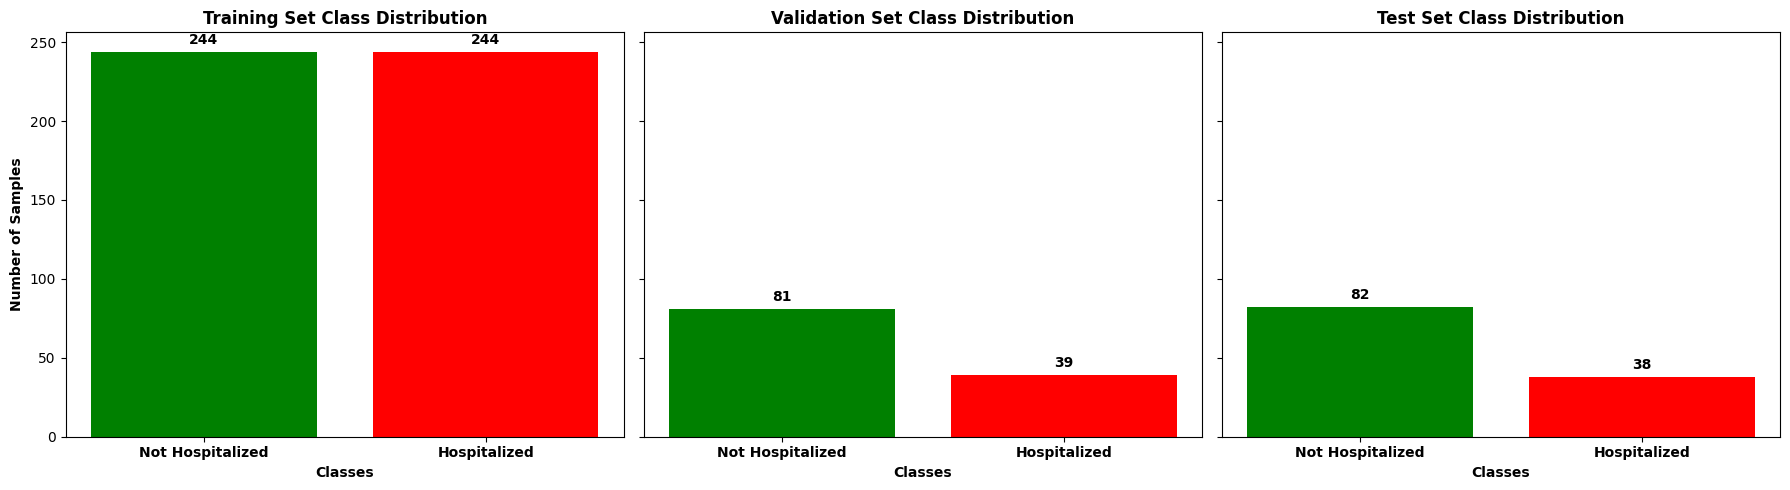

In [142]:
# Plot the class distribution for training, validation, and test sets
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Training set
train_counts = pd.Series(y_train_res).value_counts()
axes[0].bar(train_counts.index, train_counts.values, color=['red', 'green'])
axes[0].set_title('Training Set Class Distribution', fontweight='bold')
axes[0].set_xlabel('Classes', fontweight='bold')
axes[0].set_ylabel('Number of Samples', fontweight='bold')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Not Hospitalized', 'Hospitalized'], fontweight='bold')
for i, v in enumerate(train_counts.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Validation set
val_counts = pd.Series(y_val).value_counts()
axes[1].bar(val_counts.index, val_counts.values, color=['green', 'red'])
axes[1].set_title('Validation Set Class Distribution', fontweight='bold')
axes[1].set_xlabel('Classes', fontweight='bold')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Not Hospitalized', 'Hospitalized'], fontweight='bold')
for i, v in enumerate(val_counts.values):
    axes[1].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Test set
test_counts = pd.Series(y_test).value_counts()
axes[2].bar(test_counts.index, test_counts.values, color=['green', 'red'])
axes[2].set_title('Test Set Class Distribution', fontweight='bold')
axes[2].set_xlabel('Classes', fontweight='bold')
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Not Hospitalized', 'Hospitalized'], fontweight='bold')
for i, v in enumerate(test_counts.values):
    axes[2].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Integrated Model

In [143]:
# CNN Branch for Image Data
img_input = Input(shape=(21, 21, 1), name='img_input')

x = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)  

cnn_branch = Model(inputs=img_input, outputs=x)

# RF Branch for Numeric Data
tab_input = Input(shape=(1,), name='tab_input') 

y = Dense(64, activation='relu')(tab_input)

rf_branch = Model(inputs=tab_input, outputs=y)

# Fusion Layer
combined = Concatenate()([cnn_branch.output, rf_branch.output])

z = Dense(64, activation='relu')(combined)
z = Dropout(0.2)(z)
z = Dense(1, activation='sigmoid')(z)

# Final Model
model = Model(inputs=[cnn_branch.input, rf_branch.input], outputs=z)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 21, 21, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 21, 21,    │        320 │ img_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 10, 10,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 10, 10,    │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 5, 5, 64)  │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tab_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 1600)      │          0 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │        128 │ tab_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 1664)      │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │    106,560 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 1)         │         65 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 125,569 (490.50 KB)

 Trainable params: 125,569 (490.50 KB)

 Non-trainable params: 0 (0.00 B)

# Integrated Model Training

## Random Forest Training and Feature Selection

In [144]:
# Train Random Forest on Numeric Data
rf_model = RandomForestClassifier(
    n_estimators=200,         # Number of trees
    max_depth=12,             # Maximum depth of each tree
    random_state=42,         
    class_weight='balanced'  
)
rf_model.fit(X_train_scaled, y_train_res)

# Predictions (Probabilities) for Training, Validation, and Test sets
rf_train_preds = rf_model.predict_proba(X_train_scaled)[:, 1].reshape(-1, 1) 
rf_val_preds = rf_model.predict_proba(X_val_scaled)[:, 1].reshape(-1, 1)     
rf_test_preds = rf_model.predict_proba(X_test_scaled)[:, 1].reshape(-1, 1)  

# Evaluation Metrics
rf_acc = accuracy_score(y_val, (rf_val_preds > 0.5).astype(int))
rf_loss = log_loss(y_val, rf_val_preds)
print(f'Random Forest Accuracy (Numeric Data Only): {rf_acc:.4f}')
print(f'Random Forest Log Loss (Numeric Data Only): {rf_loss:.4f}')

# Verify Shapes of RF Outputs
print(f"Shape of RF Training Predictions: {rf_train_preds.shape}")
print(f"Shape of RF Validation Predictions: {rf_val_preds.shape}")
print(f"Shape of RF Test Predictions: {rf_test_preds.shape}")

Random Forest Accuracy (Numeric Data Only): 0.8667
Random Forest Log Loss (Numeric Data Only): 0.3262
Shape of RF Training Predictions: (488, 1)
Shape of RF Validation Predictions: (120, 1)
Shape of RF Test Predictions: (120, 1)


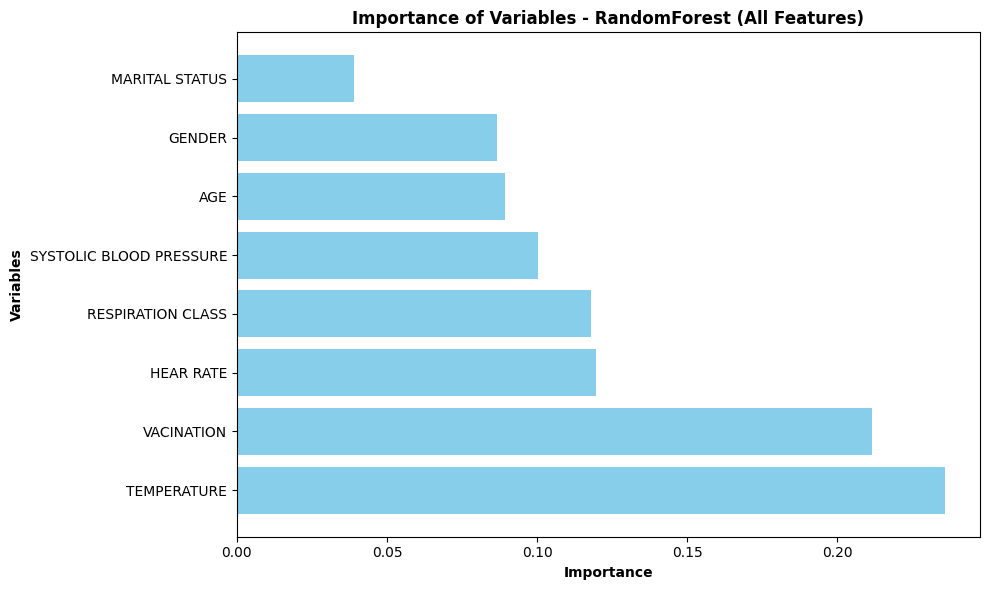

In [145]:
# Calculate Feature Importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_num.columns

plt.figure(figsize=(10, 6))
plt.title("Importance of Variables - RandomForest (All Features)", fontweight='bold')
plt.barh(feature_names[indices], importances[indices], color='skyblue')
plt.xlabel("Importance", fontweight='bold')
plt.ylabel("Variables", fontweight='bold')
plt.tight_layout()
plt.show()


Selected Features Based on Importance:
TEMPERATURE: 0.2357
VACINATION: 0.2114
HEAR RATE: 0.1196
RESPIRATION CLASS: 0.1181
SYSTOLIC BLOOD PRESSURE: 0.1004
AGE: 0.0894
GENDER: 0.0866

Reduced RF Accuracy (Numeric Data Only): 0.8500
Reduced RF Log Loss (Numeric Data Only): 0.3188


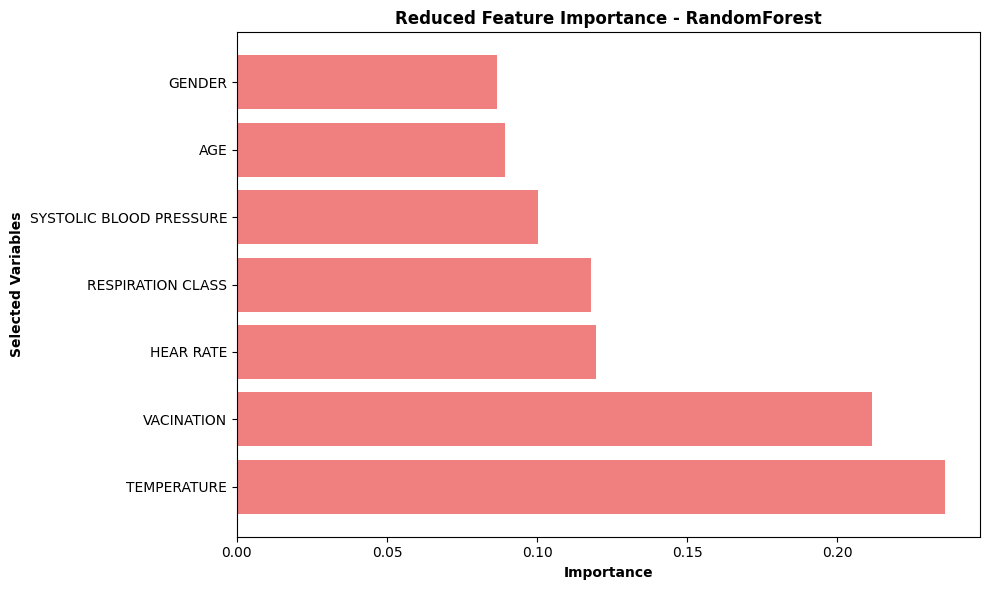

In [146]:
# Select Top Features
num_top_features = 7
selected_features = indices[:num_top_features]

print("\nSelected Features Based on Importance:")
for i in selected_features:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

# Reduce Numeric Data to Selected Features
X_train_scaled_reduced = X_train_scaled[:, selected_features]
X_val_scaled_reduced = X_val_scaled[:, selected_features]
X_test_scaled_reduced = X_test_scaled[:, selected_features]

# Retrain Random Forest on Reduced Features
rf_model_reduced = RandomForestClassifier(
    n_estimators=200,        
    max_depth=12,             
    random_state=42,          
    class_weight='balanced'  
)
rf_model_reduced.fit(X_train_scaled_reduced, y_train_res)

# Predictions (Probabilities) for Training, Validation, and Test sets
rf_train_preds = rf_model_reduced.predict_proba(X_train_scaled_reduced)[:, 1].reshape(-1, 1)
rf_val_preds = rf_model_reduced.predict_proba(X_val_scaled_reduced)[:, 1].reshape(-1, 1)
rf_test_preds = rf_model_reduced.predict_proba(X_test_scaled_reduced)[:, 1].reshape(-1, 1)

# Evaluation Metrics for Reduced RF Model
rf_acc_reduced = accuracy_score(y_val, (rf_val_preds > 0.5).astype(int))
rf_loss_reduced = log_loss(y_val, rf_val_preds)
print(f"\nReduced RF Accuracy (Numeric Data Only): {rf_acc_reduced:.4f}")
print(f"Reduced RF Log Loss (Numeric Data Only): {rf_loss_reduced:.4f}")

# Plot Reduced Feature Importance
plt.figure(figsize=(10, 6))
plt.title("Reduced Feature Importance - RandomForest", fontweight='bold')
plt.barh(feature_names[selected_features], importances[selected_features], color='lightcoral')
plt.xlabel("Importance", fontweight='bold')
plt.ylabel("Selected Variables", fontweight='bold')
plt.tight_layout()
plt.show()

## Full Training Framework

In [147]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
callbacks = [early_stopping, reduce_lr]

# Training Integrated Model
history_combined = model.fit(
    [X_train_img, rf_train_preds], 
    y_train_res,                   
    validation_data=([X_val_img, rf_val_preds], y_val), 
    epochs=200,                     
    batch_size=32,                 
    callbacks=callbacks            
)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5879 - loss: 0.6865 - val_accuracy: 0.5833 - val_loss: 0.6886 - learning_rate: 1.0000e-04
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8770 - loss: 0.6753 - val_accuracy: 0.7417 - val_loss: 0.6818 - learning_rate: 1.0000e-04
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9329 - loss: 0.6620 - val_accuracy: 0.8250 - val_loss: 0.6723 - learning_rate: 1.0000e-04
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9804 - loss: 0.6457 - val_accuracy: 0.8250 - val_loss: 0.6631 - learning_rate: 1.0000e-04
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9958 - loss: 0.6341 - val_accuracy: 0.8250 - val_loss: 0.6566 - learning_rate: 1.0000e-04
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9921 - loss: 0.6222 - val_accuracy: 0.8250 - val_loss: 0.6484 - learning_rate: 1.0000e-04
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9947

# Analysis after Integrated Model Training

## Training and Validation

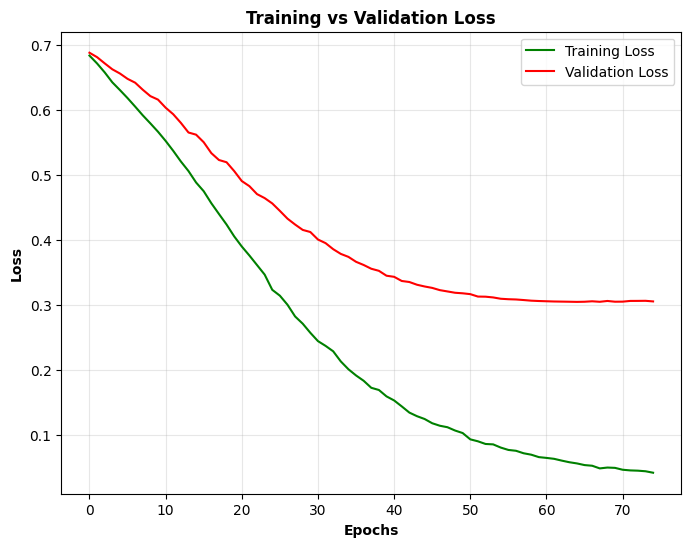

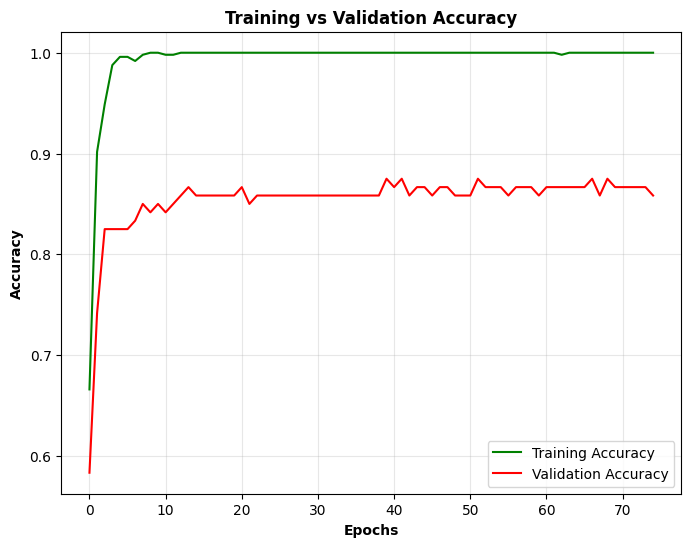

In [148]:
# Plot Training vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history_combined.history['loss'], label='Training Loss', color='green')
plt.plot(history_combined.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.title('Training vs Validation Loss', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot Training vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history_combined.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history_combined.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Training vs Validation Accuracy', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Test

In [154]:
# Combined Evaluation (CNN + RF)
test_preds = model.predict([X_test_img, rf_test_preds.reshape(-1, 1)]) 
test_preds = (test_preds > 0.5).astype(int)

acc = accuracy_score(y_test, test_preds)
print(f'\nFinal Test Accuracy (CNN + RF): {acc:.4f}')

loss = log_loss(y_test, test_preds)
print(f'Final Log Loss (CNN + RF): {loss:.4f}')

print("\nClassification Report: ")
print(classification_report(y_test, test_preds, target_names=['Not Hospitalized', 'Hospitalized']))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Final Test Accuracy (CNN + RF): 0.8417
Final Log Loss (CNN + RF): 5.7069

Classification Report: 
                  precision    recall  f1-score   support

Not Hospitalized       0.87      0.90      0.89        82
    Hospitalized       0.77      0.71      0.74        38

        accuracy                           0.84       120
       macro avg       0.82      0.81      0.81       120
    weighted avg       0.84      0.84      0.84       120




Confusion Matrix: 
[[74  8]
 [11 27]]


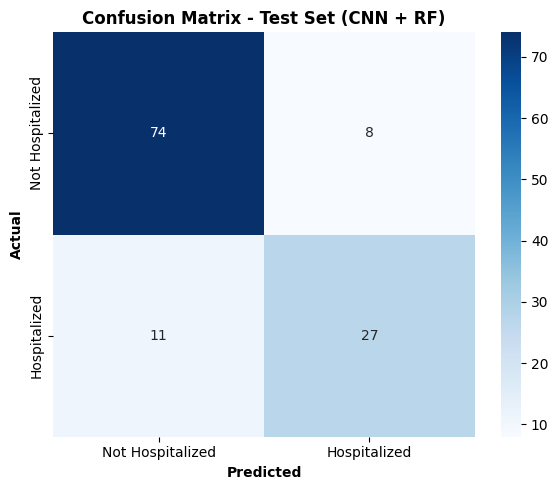

In [152]:
print("\nConfusion Matrix: ")
cm = confusion_matrix(y_test, test_preds)
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=['Not Hospitalized', 'Hospitalized'], 
    yticklabels=['Not Hospitalized', 'Hospitalized']
)
plt.title('Confusion Matrix - Test Set (CNN + RF)', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
ROC AUC Score: 0.8983


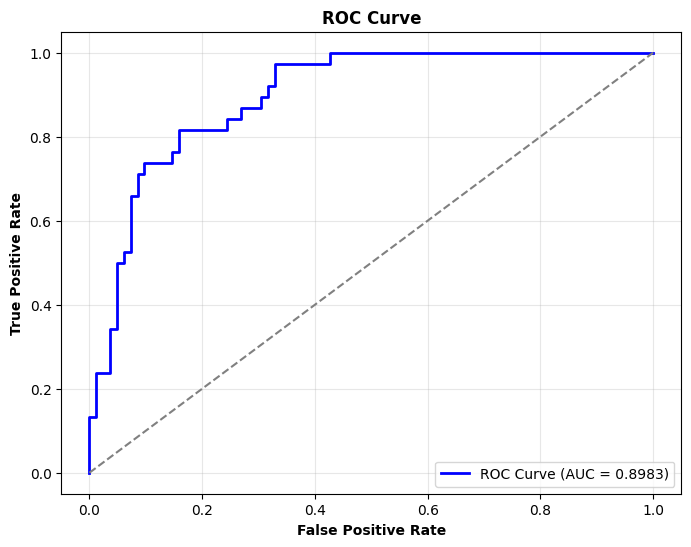

In [150]:
y_test_probs = model.predict([X_test_img, rf_test_preds])

roc_auc = roc_auc_score(y_test, y_test_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curve', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()